<a href="https://colab.research.google.com/github/nickhward/Aubo-Pick-And-Place/blob/main/BertClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BERT Classifier for Sentence Classification**
This notebook aims to create a BERT classifier to classify sentences into categories such as job description, job required skills, education, or none of the previous. The notebook consists of several sections: setting up the text and labels, data preprocessing, augmentation using back translation, training the model, and saving it for future use in the pipeline. Additionally, the Google Colab GPU will be utilized to enhance processing speed.

## **Setting up Text and Labels**
First, the text and labels need to be processed and prepared for the BERT model. The following steps are involved:

1. Define a label map to assign numerical values to each label category.
2. Define a function label_sentences() to tokenize the text into sentences and assign labels.
3. Load the data and process it to obtain the labeled sentences.
4. Peform text data augmentation by implementing a function back_translate() to perform back translation using an intermediate language (e.g., French).

## **Training the BERT Classifier**
Once the text and labels are prepared, the BERT classifier can be trained. The training process involves the following steps:

1. Load the preprocessed text and labels into the BERT model.
2. Fine-tune the BERT model on the training dataset using techniques such as gradient descent and backpropagation.
3. Evaluate the performance of the trained model on a validation dataset to assess its accuracy and adjust hyperparameters if necessary.

## **Utilizing Google Colab GPU**
To leverage the GPU capabilities of Google Colab for accelerated processing, follow these steps:

1. Connect to a Google Colab instance that offers GPU support.
2. Verify that the GPU is enabled and accessible from the notebook.
3. Utilize the GPU during the training process by specifying the appropriate configurations and GPU-specific optimizations.

By following the above steps, you can set up the text and labels, preprocess the data, augment the dataset using back translation, train the BERT classifier, and take advantage of the Google Colab GPU for enhanced performance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install nlpaug
!pip install googletrans==4.0.0-rc1
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 21.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 65.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 4.7 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=8c711c95e6ade114866601

In [3]:
import json
import nltk
from googletrans import Translator
from tqdm import tqdm
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from transformers import BertTokenizerFast, BertForSequenceClassification
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers import XLNetTokenizerFast, XLNetForSequenceClassification
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification
from sklearn.metrics import confusion_matrix
import seaborn as sns
from typing import List, Tuple
import pandas as pd
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
label_map = {
    "SCHOOL": 0,
    "SKILLS": 1,
    "JOBDES": 2,
}

def back_translate(sentence, intermediate_lang='fr'):
    translator = Translator()
    
    # Translate to the intermediate language
    translated_sentence = translator.translate(sentence, dest=intermediate_lang).text
    
    # Translate back to English
    back_translated_sentence = translator.translate(translated_sentence, dest='en').text
    
    return back_translated_sentence

def label_sentences(data):
    sentences = nltk.tokenize.sent_tokenize(data['text'])
    sentence_labels = []

    # Create a list the size of the sentences, filled with -1 (representing no label)
    for _ in sentences:
        sentence_labels.append(-1)

    for label in data['label']:
        start, end, label_text = label

        # Find the sentence containing the start of the label
        for i, sentence in enumerate(sentences):
            if start <= len(sentence):
                # This sentence contains the start of the label. It and all following sentences
                # are labeled with label_text until we reach a sentence that starts after the end of the label.
                while start <= len(sentence) <= end:
                    if i < len(sentence_labels):   # Ensure the index is within range
                        sentence_labels[i] = label_map[label_text]
                        i += 1
                    else:
                        break
                    if i < len(sentences):
                        sentence = sentences[i]
                break
            start -= len(sentence) + 1  # +1 for the space that was removed by nltk.tokenize.sent_tokenize
            end -= len(sentence) + 1
    
    return sentences, sentence_labels

sentences_all = []
labels_all = []

# Load your data
with open('/content/drive/MyDrive/admin.jsonl') as f:
    for line in f:
        data = json.loads(line)
        sentences, labels = label_sentences(data)
        sentences_all.extend(sentences)
        labels_all.extend(labels)

# Augment each class with back translation
augmented_sentences_all = []
augmented_labels_all = []


for i in tqdm(range(len(labels_all)), desc='Back-translating sentences'):
    if labels_all[i] == -1:
        labels_all[i] = 3

    # Augment the sentence
    try:
        augmented_sentence = back_translate(sentences_all[i])
        augmented_sentences_all.append(augmented_sentence)
        augmented_labels_all.append(labels_all[i])  # The label remains the same
    except:
        continue

sentences_all.extend(augmented_sentences_all)
labels_all.extend(augmented_labels_all)



Back-translating sentences: 100%|██████████| 1311/1311 [10:36<00:00,  2.06it/s]


In [5]:
print(len(labels_all))
print(set(labels_all))
print(sentences_all[5])

2498
{0, 1, 2, 3}
We focus on Life Science, Healthcare, Energy & Utilities and CPG sectors and work with various data sets, from social media to public health data.


In [6]:
print(pd.Series(labels_all).value_counts())

2    1263
1     700
3     503
0      32
dtype: int64


In [10]:

class JobPostingClassifier:
    """A Job Posting classifier with the possibility of using various types of BERT models."""

    def __init__(self, sentences: List[str], labels: List[int], model_name: str = 'distilbert-base-cased', num_labels: int = 4, device: str = 'cpu'):
        """
        Initializes the JobPostingClassifier with given sentences and labels.

        Args:
            sentences (List[str]): The sentences used for training the model.
            labels (List[int]): The labels corresponding to the sentences.
            model_name (str, optional): The name of the pretrained model. Defaults to 'distilbert-base-cased'.
            num_labels (int, optional): The number of unique labels. Defaults to 4.
            device (str, optional): The device on which to run computations ('cpu' or 'cuda'). Defaults to 'cpu'.
        """

        self.tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

        if 'distilbert' in model_name:
            self.tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)
            self.model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        elif 'bert' in model_name:
            self.tokenizer = BertTokenizerFast.from_pretrained(model_name)
            self.model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        elif 'roberta' in model_name:
            self.tokenizer = RobertaTokenizerFast.from_pretrained(model_name)
            self.model = RobertaForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
 

        sentences_train, sentences_val, labels_train, labels_val = train_test_split(sentences, labels, test_size=0.2, stratify=labels)


        self.dataset_train = self.__create_dataset(sentences_train, labels_train)
        self.dataset_val = self.__create_dataset(sentences_val, labels_val)
        
        self.dataloader_train = DataLoader(self.dataset_train, batch_size=16)
        self.dataloader_val = DataLoader(self.dataset_val, batch_size=16)

        if torch.cuda.is_available() and device=='cuda':
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')

        self.model.to(self.device)

        self.optim = torch.optim.AdamW(params=self.model.parameters(), lr=1e-4, weight_decay=1e-5)

    
    class SentenceClassificationDataset(Dataset):
        """
        Helps create a PyTorch Dataset for sentence classification tasks.
        """
        def __init__(self, sentences, labels, tokenizer):
            self.sentences = sentences
            self.labels = labels
            self.tokenizer = tokenizer

        def __len__(self):
            return len(self.sentences)

        def __getitem__(self, idx):
            sentence = self.sentences[idx]
            label = self.labels[idx]

            encoding = self.tokenizer.encode_plus(sentence, truncation=True, padding='max_length', max_length=512)

            items = {key: torch.tensor(val) for key, val in encoding.items()}
            items['labels'] = torch.tensor(label)
            
            return items

    def __create_dataset(self, sentences: List[str], labels: List[int]) -> SentenceClassificationDataset:
        """
        Creates a SentenceClassificationDataset with the provided sentences and labels.

        Args:
            sentences (List[str]): The sentences.
            labels (List[int]): The labels.

        Returns:
            SentenceClassificationDataset: The created dataset.
        """

        return self.SentenceClassificationDataset(sentences, labels, self.tokenizer)
    
    def __compute_metrics(self, preds: np.ndarray, labels: np.ndarray) -> dict:
        """
        Computes and returns evaluation metrics.

        Args:
            preds (np.ndarray): The predicted labels.
            labels (np.ndarray): The true labels.

        Returns:
            dict: A dictionary with evaluation metrics.
        """

        preds_flat = preds.flatten()
        labels_flat = labels.flatten()
        accuracy = accuracy_score(labels_flat, preds_flat)
        precision = precision_score(labels_flat, preds_flat, average='micro')
        recall = recall_score(labels_flat, preds_flat, average='micro')
        f1 = f1_score(labels_flat, preds_flat, average='micro')

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }


    def train(self, epochs: int, patience: int):
        """
        Trains the model for a specified number of epochs.

        Args:
            epochs (int): The number of epochs for which to train the model.
            patience (int): The number of epochs to wait for improvement before stopping training early.
        """

        best_val_loss = float('inf')
        early_stopping_counter = 0
        metrics_history = {
            'train': [],
            'val': [],
        }

        for epoch in range(epochs):
            # Training
            self.model.train()
            train_loss = 0
            train_outputs, train_labels = [], []
            train_bar = tqdm(self.dataloader_train, desc=f'Training Epoch {epoch}', leave=False, disable=False)
            for batch in train_bar:
                self.optim.zero_grad()

                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
                
                # Store outputs and labels for metrics calculation
                train_outputs.append(outputs.logits.argmax(dim=-1).cpu().numpy())
                train_labels.append(labels.cpu().numpy())

                loss = outputs.loss
                loss.backward()

                self.optim.step()

                train_loss += loss.item()
                train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})

            train_outputs = np.concatenate(train_outputs, axis=0)
            train_labels = np.concatenate(train_labels, axis=0)
            train_metrics = self.__compute_metrics(train_outputs, train_labels)
            metrics_history['train'].append(train_metrics)

            # Validation
            self.model.eval()
            val_loss = 0
            val_bar = tqdm(self.dataloader_val, desc=f'Validation Epoch {epoch}', leave=False, disable=False)
            val_outputs, val_labels = [], []

            for batch in val_bar:
                with torch.no_grad():  # Disabling gradient calculation
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    outputs = self.model(input_ids, attention_mask=attention_mask, labels=labels)
        
                    # Store outputs and labels for metrics calculation
                    val_outputs.append(outputs.logits.argmax(dim=-1).cpu().numpy())
                    val_labels.append(labels.cpu().numpy())

                    loss = outputs.loss
                    val_loss += loss.item()

            val_outputs = np.concatenate(val_outputs, axis=0)
            val_labels = np.concatenate(val_labels, axis=0)
            val_metrics = self.__compute_metrics(val_outputs, val_labels)
            metrics_history['val'].append(val_metrics)

            print(f"Epoch {epoch}, Training loss {train_loss/len(self.dataloader_train)}, Validation loss {val_loss/len(self.dataloader_val)}")

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                early_stopping_counter = 0  # Reset counter
            else:
                early_stopping_counter += 1  # Increment counter

            if early_stopping_counter >= patience:
                print("Early stopping!")
                break
                

        print("Final Metrics:")
        for phase in ['train', 'val']:
            print(f"{phase.capitalize()} Metrics:")
            metrics = metrics_history[phase][-1]  # Get the last recorded metrics
            for metric_name, metric_value in metrics.items():
                print(f"{metric_name}: {metric_value}")

        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            plt.figure()
            plt.plot([m[metric] for m in metrics_history['train']], label='Train')
            plt.plot([m[metric] for m in metrics_history['val']], label='Val')
            plt.title(f'{metric} over epochs')
            plt.xlabel('Epochs')
            plt.ylabel(metric)
            plt.legend()
            plt.show()

        # Compute confusion matrix on validation data
        # Note that 'val_preds_flat' and 'val_labels_flat' should be your actual predictions and labels for the validation phase
        cm = confusion_matrix(val_labels.flatten(), val_outputs.flatten())

        # Display confusion matrix
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion matrix on validation data')
        plt.show()

    def predict(self, sentence):
        self.model.eval()  # Set model to evaluation mode
        
        # Prepare the sentence in the way the model expects
        encoding = self.tokenizer.encode_plus(
            sentence, 
            truncation=True, 
            padding='max_length', 
            max_length=512,
            return_tensors='pt'  # Return PyTorch tensors
        )
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():  # Disabling gradient calculation
            outputs = self.model(input_ids, attention_mask=attention_mask)

        # The outputs are logits, we need to convert these to probabilities
        # by applying the softmax function
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        # Multiply by 100 to convert the probabilities to percentages
        percentages = probabilities * 100

        # Printing the percentages
        for i, percentage in enumerate(percentages[0]):
            print(f"Class {i}: {percentage:.2f}%")
        
        # The result is a tensor where the first index is the batch size (1 in this case),
        # the second index is the label index, and the value is the probability.
        # We want the label with the highest probability, so we'll use argmax to find it
        predicted_label = probabilities.argmax().item()

        return predicted_label
    
    def save_model(self): 
        torch.save(self.model.state_dict(), 'model_bert_1.pth')


Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier

Epoch 0, Training loss 1.0151017694473266, Validation loss 0.8334289360791445


Epoch 1, Training loss 0.6974073495864869, Validation loss 0.7295218659564853


Epoch 2, Training loss 0.44471137869358063, Validation loss 0.6773332820739597


Epoch 3, Training loss 0.31821833369135855, Validation loss 0.6240851758047938


Epoch 4, Training loss 0.26086436907202004, Validation loss 0.5692788935266435


Epoch 5, Training loss 0.20996891252696515, Validation loss 0.5304064692463726


Epoch 6, Training loss 0.15383702809363603, Validation loss 0.5808212396223098


Epoch 7, Training loss 0.14167374255508183, Validation loss 0.663268482661806


Epoch 8, Training loss 0.16124410572461784, Validation loss 0.6022756984457374


Epoch 9, Training loss 0.12122551456652582, Validation loss 0.640262610046193


Epoch 10, Training loss 0.09141241404041647, Validation loss 0.9214983955171192
Early stopping!
Final Metrics:
Train Metrics:
accuracy: 0.9529529529529529
precision: 0.9529529529529529
recall: 0.9529529529529529
f1: 0.9529529529529529
Val Metrics:
accuracy: 0.828
precision: 0.828
recall: 0.828
f1: 0.828


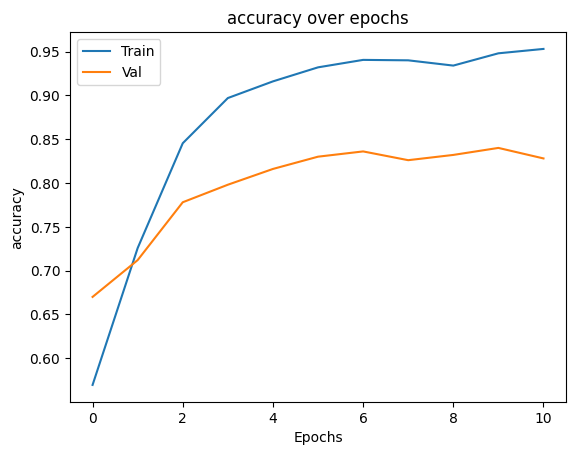

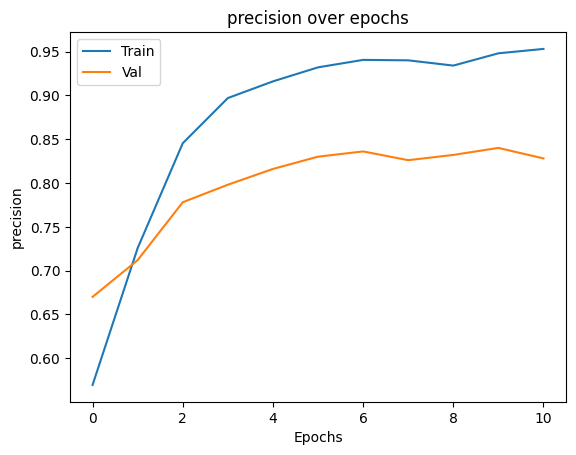

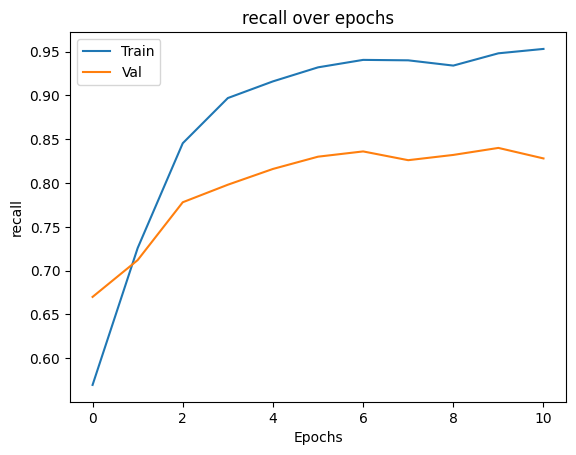

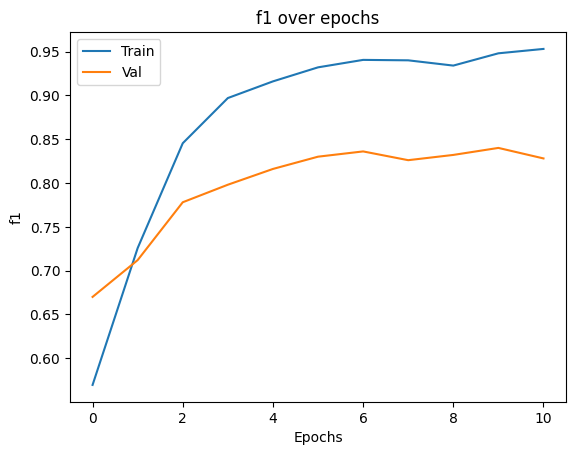

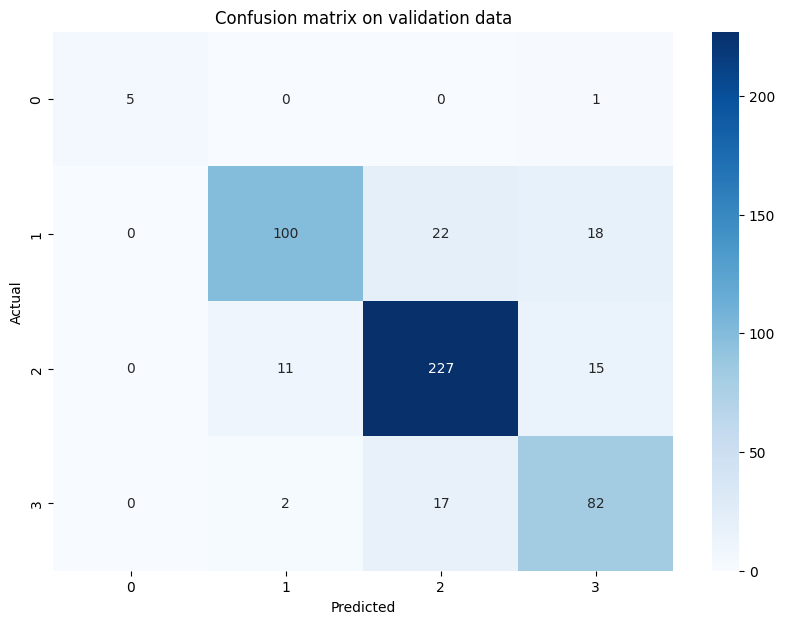

In [11]:
classifier = JobPostingClassifier(sentences_all, labels_all, device='cuda')
classifier.train(epochs=100, patience=5)

In [12]:
sentence = '''
We’re redefining excellent customer experiences. Data drives that process.
'''
predicted_label = classifier.predict(sentence)
print(predicted_label)  # Will print the index of the label, e.g. 2 for JOBDES

Class 0: 0.00%
Class 1: 0.21%
Class 2: 99.78%
Class 3: 0.01%
2


In [ ]:
#classifier.save_model()